# Normal Integration

## Functional Interface
| *function*  |   CuPy   |    JAX    |   Numba   |   NumPy   |  PyTorch  |
| :---------: | :------: | :-------: | :-------: | :-------: | :-------: |
|   arnison   | &#10067; | &#128994; | &#128994; | &#128994; | &#128994; |
| dct_poisson | &#10067; | &#128994; | &#128994; | &#128994; | &#128994; |
| dst_poisson | &#10067; | &#128994; | &#128994; | &#128994; | &#128994; |
|   frankot   | &#10067; | &#128994; | &#128994; | &#128994; | &#128994; |
|   kottler   | &#10067; | &#128994; | &#128994; | &#128994; | &#128994; |
|     li      | &#10067; | &#10067;  | &#128308; | &#128994; | &#128308; |
|  southwell  | &#10067; | &#10067;  | &#128308; | &#128994; | &#128308; |

## OOP Interface
|  *class*  |   CuPy   |    JAX    |   Numba   |   NumPy   |  PyTorch  |
| :-------: | :------: | :-------: | :-------: | :-------: | :-------: |
|    Li     | &#10067; | &#128308; | &#128308; | &#128994; | &#128308; |
| Southwell | &#10067; | &#128308; | &#128308; | &#128994; | &#128308; |


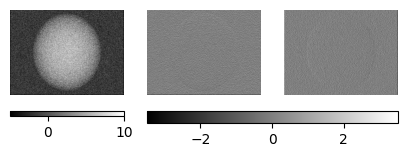

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.testing import assert_allclose

from mbipy.normal_integration import (
    arnison,
    dct_poisson,
    dst_poisson,
    frankot,
    kottler,
    li,
    southwell,
)

M, N = 617, 823

x = np.linspace(-10, 10, N)
y = np.linspace(-10, 10, M)[:, None]

Z = np.emath.sqrt(9**2 - (x * 1.5) ** 2 - y**2).real

rng = np.random.default_rng(0)

Z[2:-2, 2:-2] += rng.random(Z[2:-2, 2:-2].shape) * 15
Z -= Z.mean()

gy, gx = np.gradient(Z)

methods = arnison, dct_poisson, dst_poisson, frankot, kottler, li, southwell
_methods = methods[:-2]

figsize = (1.5 * len(methods), 3)

fig, axs = plt.subplots(1, 3, figsize=(5, 5))
for i in axs:
    i.axis("off")
im0 = axs[0].imshow(Z, cmap="gray", vmin=-5, vmax=10)
im1 = axs[1].imshow(gy, cmap="gray", vmin=-3.5, vmax=3.5)
im2 = axs[2].imshow(gx, cmap="gray", vmin=-3.5, vmax=3.5)
fig.colorbar(im0, ax=axs[0], orientation="horizontal", fraction=0.046, pad=0.04) 
fig.colorbar(im1, ax=axs[1:], orientation="horizontal", fraction=0.046, pad=0.04)


def plot(method, ax, gy, gx, ground_truth, cbar=False):
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[0].set_title(method.__name__)
    try:
        result = method(gy, gx)
        result -= result.mean()
    except NotImplementedError as e:
        print(f"{method.__name__}: {e}")
        ax[0].imshow(np.ones_like(Z), cmap="gray")
        ax[1].imshow(np.ones_like(Z), cmap="gray")
        return
    im0 = ax[0].imshow(result, cmap="gray", vmin=-5, vmax=10)
    im1 = ax[1].imshow(result - ground_truth, cmap="gray", vmin=-0.01, vmax=0.01)
    
    return result, im0, im1

# NumPy

numpy.ndarray

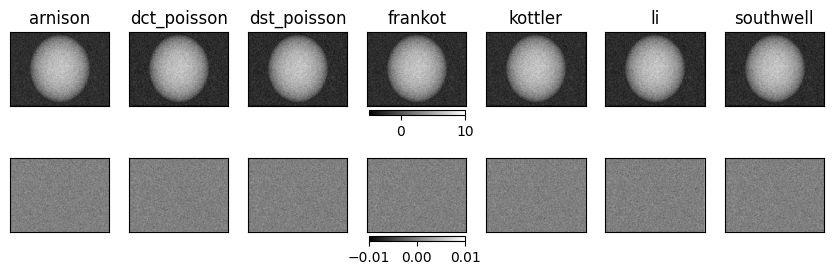

In [2]:
results_numpy = {}
fig, axs = plt.subplots(2, len(methods), figsize=figsize)
for i, m in enumerate(methods):
    result, im0, im1 = plot(m, axs[:, i], gy, gx, Z)
    results_numpy[m.__name__] = result
    
fig.colorbar(im0, ax = axs[0, :], orientation="horizontal", fraction=0.046, pad=0.04)
fig.colorbar(im1, ax = axs[1, :], orientation="horizontal", fraction=0.046, pad=0.04)
type(result)

In [3]:
from mbipy.normal_integration import Southwell, Li

_southwell = Southwell(gy.shape, fdtype=np.float64)
_li = Li(gy.shape, fdtype=np.float64)


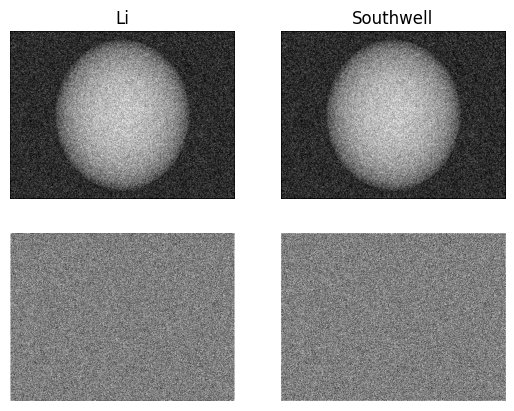

In [4]:
fig, ax = plt.subplots(2, 2)
for i in ax.flat:
    i.axis("off")
for i, m in enumerate((_li, _southwell)):
    ax[0, i].set_title(m.__class__.__name__)
    result = m(gy.astype(np.float32), gx.astype(np.float32))
    result -= result.mean()
    im0 = ax[0, i].imshow(result, cmap="gray", vmin=-5, vmax=10)
    im1 = ax[1, i].imshow(result - Z, cmap="gray", vmin=-0.01, vmax=0.01)

# Numba

numpy.ndarray

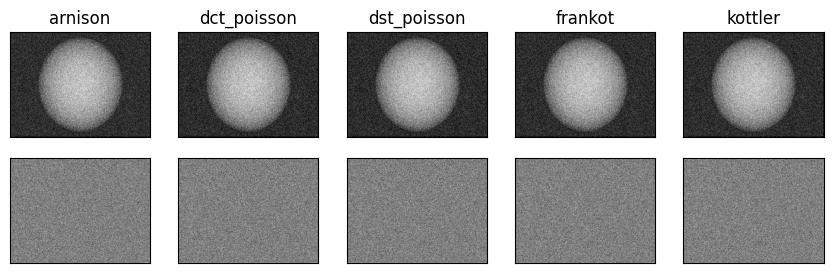

In [5]:
from numba import njit

fig, axs = plt.subplots(2, len(_methods), figsize=figsize)
for i, m in enumerate(_methods):
    result, *_ = plot(njit(m), axs[:, i], gy, gx, Z)
    if result is not None:
        assert_allclose(result, results_numpy[m.__name__])
type(result)

# JAX

jaxlib.xla_extension.ArrayImpl

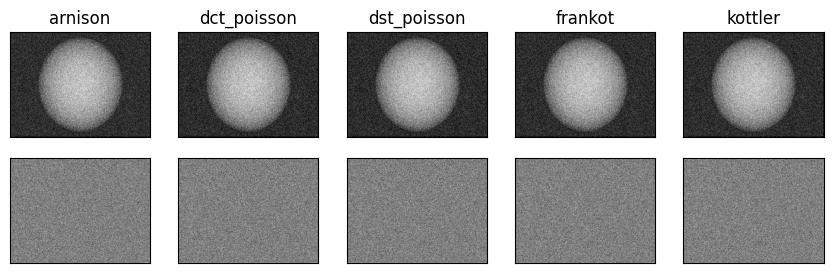

In [6]:
from jax import config, jit, numpy as jnp

config.update("jax_enable_x64", True)

gy_jax, gx_jax = jnp.array(gy), jnp.array(gx)

fig, axs = plt.subplots(2, len(_methods), figsize=figsize)
for i, m in enumerate(_methods):
    result, *_ = plot(jit(m), axs[:, i], gy_jax, gx_jax, Z)
    if result is not None:
        assert_allclose(result, results_numpy[m.__name__])
type(result)

# PyTorch

torch.Tensor

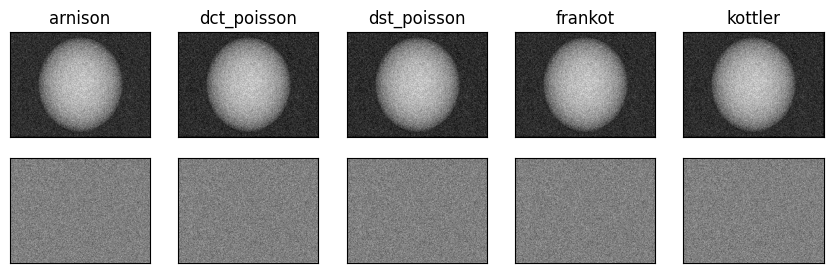

In [7]:
import torch

gy_torch, gx_torch = torch.tensor(gy), torch.tensor(gx)
fig, axs = plt.subplots(2, len(_methods), figsize=figsize)
for i, m in enumerate(_methods):
    Z_torch = torch.tensor(Z)
    result, *_ = plot(m, axs[:, i], gy_torch, gx_torch, Z_torch)
    if result is not None:
        assert_allclose(result, results_numpy[m.__name__], rtol=1e-7, atol=1e-5)
type(result)

# CuPy

In [8]:
import cupy as cp

gy_cupy, gx_cupy = cp.array(gy), cp.array(gx)

fig, axs = plt.subplots(2, len(methods), figsize=figsize)
for i, m in enumerate(methods):
    Z_cupy, *_ = cp.array(Z)
    plot(lambda gy, gx: m(gy, gx).get(), axs[:, i], gy_cupy, gx_cupy, Z_cupy)
type(result)

ModuleNotFoundError: No module named 'cupy'